In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import torch
from PFNExperiments.Evaluation.Evaluate import Evaluate
from pyro.infer.autoguide import AutoMultivariateNormal
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC
from PFNExperiments.LinearRegression.ComparisonModels.Variational_InferenceAutoguide import Variational_InferenceAutoguide

from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code




In [28]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig

make_lm_program = make_lm_program_ig
make_lm_program_batched = make_lm_program_ig_batched

pprogram_batched = make_lm_program_batched()



pprogram_y = return_only_y(pprogram)

a = 5.0
b = 2.0
tau = 1.0

curriculum = Curriculum(max_iter=int(1))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(tau)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),

    ]
)



####################################################################################################
Epoch 0


100%|██████████| 1000/1000 [00:00<00:00, 1752.52it/s]


{'X': {'mean': tensor(0.5001), 'variance': tensor(0.0834), 'min': tensor(0.), 'max': tensor(1.0000)}, 'y': {'mean': tensor(-0.0030), 'variance': tensor(1.3486), 'min': tensor(-13.4333), 'max': tensor(18.1305)}, 'beta': {'mean': tensor([-0.0062, -0.0002,  0.0040]), 'variance': tensor([0.9976, 1.0116, 1.0292]), 'min': tensor([-3.4748, -3.8783, -3.6311]), 'max': tensor([3.5970, 4.0896, 3.4182])}}
Statistics for sigma_squared:
Mean: tensor([0.5010])
Variance: tensor([0.0845])
Min: tensor([0.1084])
Max: tensor([5.5911])


Statistics for time:
Mean: 0.5013505890369415
Variance: 0.08440537474271913
Min: 0.0002796053886413574
Max: 0.9998738169670105


Statistics for base_sample_beta:
Mean: tensor([-0.0016,  0.0010,  0.0040])
Variance: tensor([1.0065, 1.0010, 1.0114])
Min: tensor([-4.0818, -3.6736, -3.5493])
Max: tensor([3.7713, 3.8424, 4.0440])




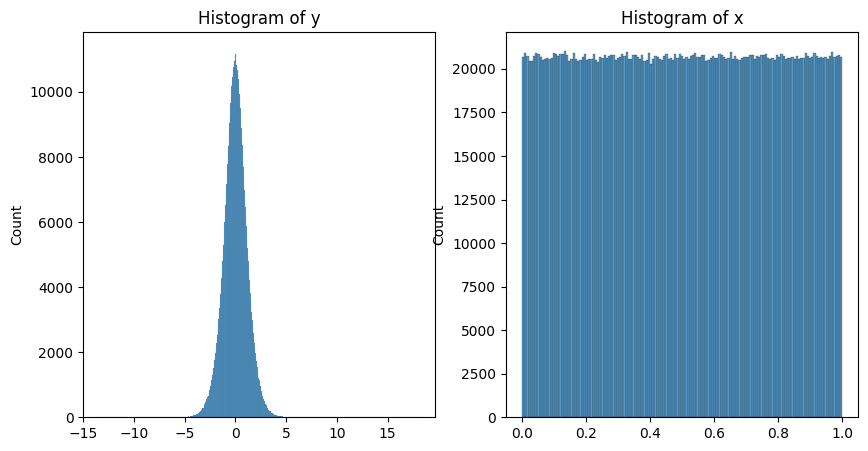

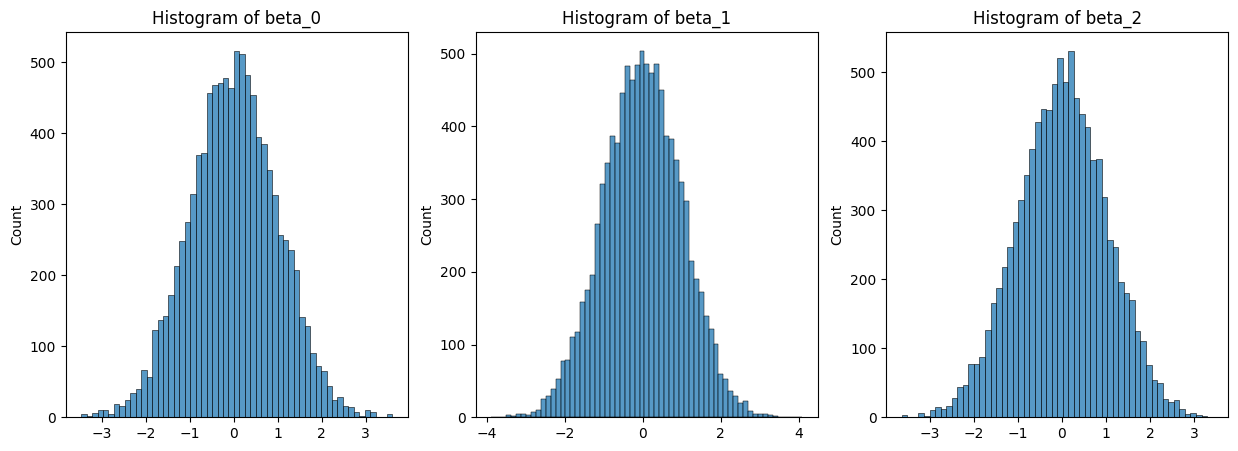

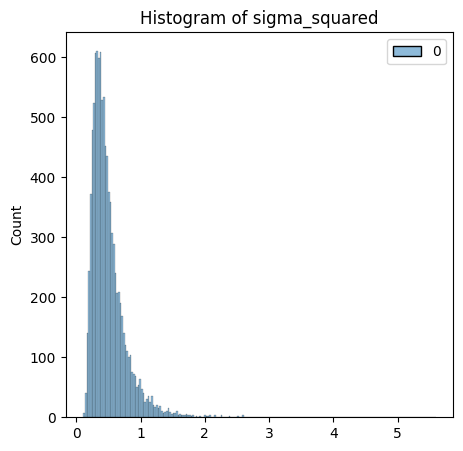

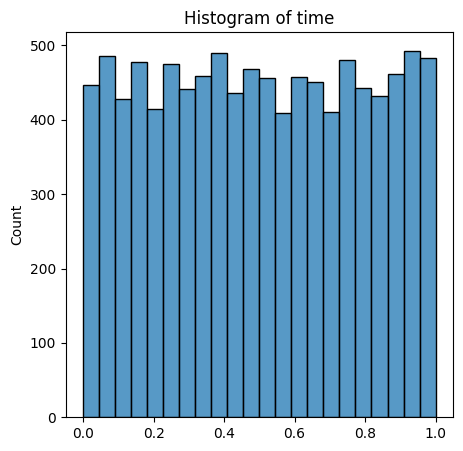

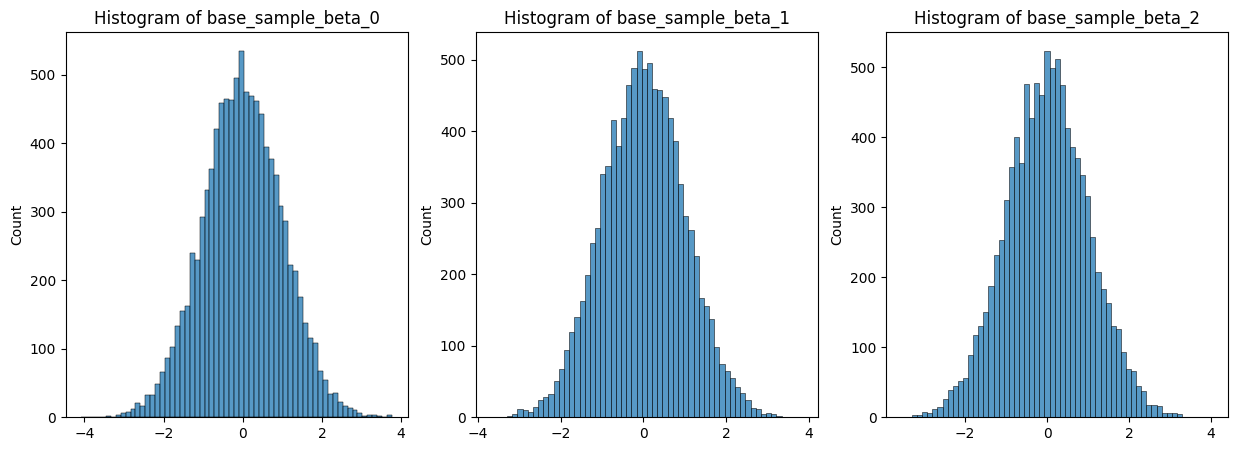

####################################################################################################
Epoch 10


100%|██████████| 1000/1000 [00:00<00:00, 1957.80it/s]


{'X': {'mean': tensor(0.4998), 'variance': tensor(0.0834), 'min': tensor(0.), 'max': tensor(1.0000)}, 'y': {'mean': tensor(0.0057), 'variance': tensor(1.3318), 'min': tensor(-15.2658), 'max': tensor(16.3777)}, 'beta': {'mean': tensor([0.0021, 0.0038, 0.0025]), 'variance': tensor([0.9835, 1.0095, 1.0057]), 'min': tensor([-3.9810, -3.7675, -4.4699]), 'max': tensor([3.5406, 3.7647, 3.9744])}}
Statistics for sigma_squared:
Mean: tensor([0.5034])
Variance: tensor([0.0843])
Min: tensor([0.1094])
Max: tensor([5.3625])


Statistics for time:
Mean: 0.4992732219040394
Variance: 0.08380944613240493
Min: 5.555152893066406e-05
Max: 0.999968409538269


Statistics for base_sample_beta:
Mean: tensor([ 0.0139, -0.0011,  0.0042])
Variance: tensor([1.0071, 0.9805, 1.0039])
Min: tensor([-3.6758, -3.2294, -3.5973])
Max: tensor([3.8739, 4.1046, 3.7919])




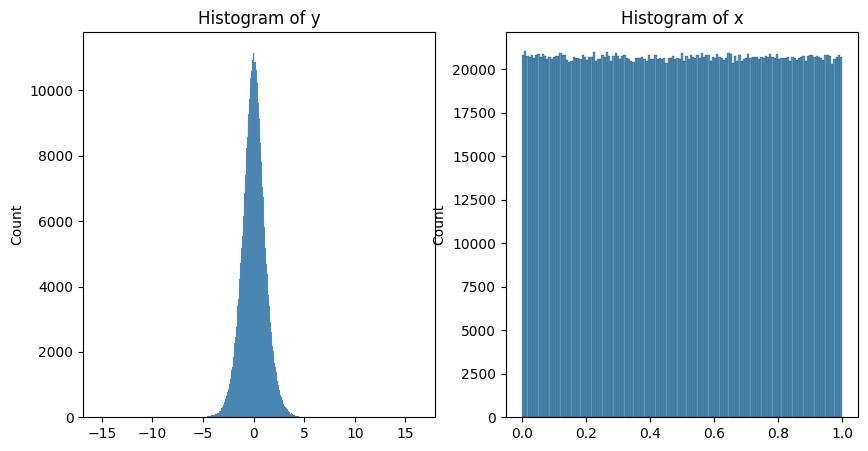

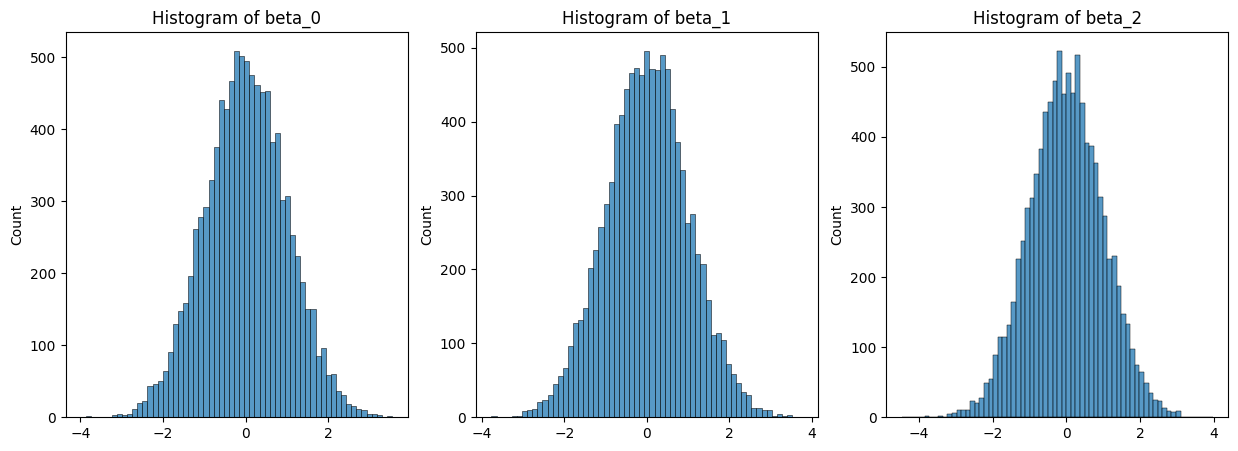

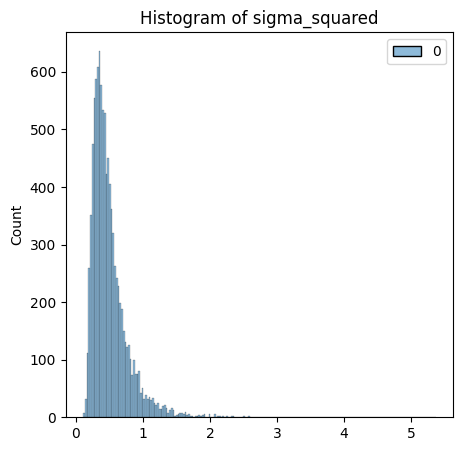

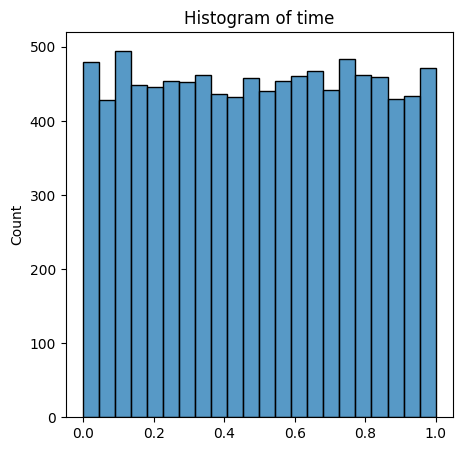

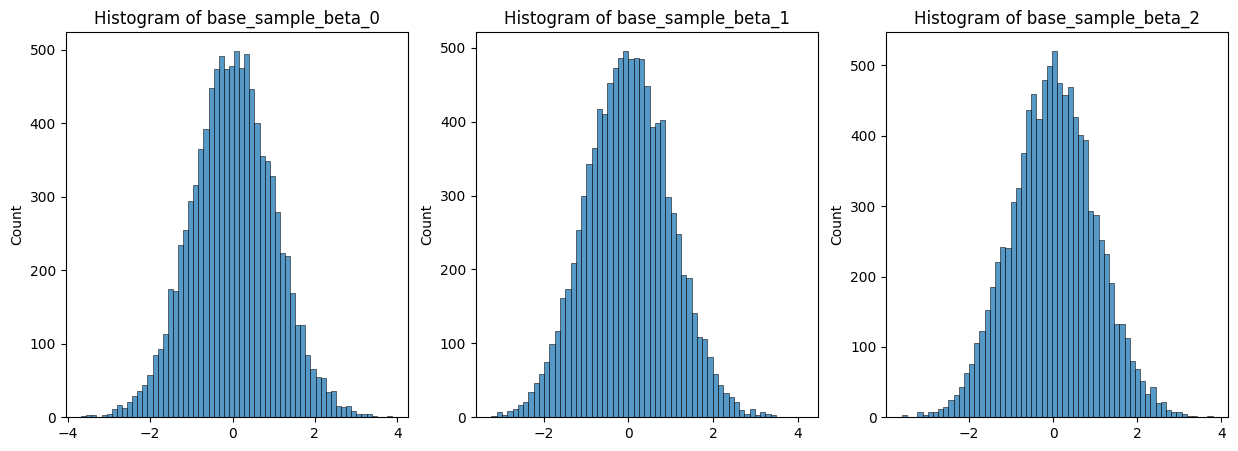

[{'X': {'mean': tensor(0.5001),
   'variance': tensor(0.0834),
   'min': tensor(0.),
   'max': tensor(1.0000)},
  'y': {'mean': tensor(-0.0030),
   'variance': tensor(1.3486),
   'min': tensor(-13.4333),
   'max': tensor(18.1305)},
  'beta': {'mean': tensor([-0.0062, -0.0002,  0.0040]),
   'variance': tensor([0.9976, 1.0116, 1.0292]),
   'min': tensor([-3.4748, -3.8783, -3.6311]),
   'max': tensor([3.5970, 4.0896, 3.4182])}},
 {'X': {'mean': tensor(0.4998),
   'variance': tensor(0.0834),
   'min': tensor(0.),
   'max': tensor(1.0000)},
  'y': {'mean': tensor(0.0057),
   'variance': tensor(1.3318),
   'min': tensor(-15.2658),
   'max': tensor(16.3777)},
  'beta': {'mean': tensor([0.0021, 0.0038, 0.0025]),
   'variance': tensor([0.9835, 1.0095, 1.0057]),
   'min': tensor([-3.9810, -3.7675, -4.4699]),
   'max': tensor([3.5406, 3.7647, 3.9744])}}]

In [20]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_ig_batched,
    curriculum= curriculum,
    #coupling = None
)

data_generator.check_model(
    n_samples_per_epoch=10,
    batch_size=32
)

In [21]:
dataloader_train, dataloader_val, dataloader_test = data_generator.make_dataloaders_for_epoch_dynamic(epoch = 0, n = 100, p = 5, n_samples_per_epoch=100, batch_size=32)

In [22]:
N_SAMPLES_PER_MODEL = 100

In [29]:
pprogram = make_lm_program(**data_generator.curriculum.get_params(-1))
pprogram_y = return_only_y(pprogram)


In [30]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram_y, n_warmup=500, n_samples=N_SAMPLES_PER_MODEL)

vi_multivariate_normal = Variational_InferenceAutoguide(
    pprogram=pprogram_y,
    make_guide_fun = AutoMultivariateNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

In [33]:
evaluation = Evaluate(
    posterior_model = hmc_sampler,
    evaluation_loader = dataloader_train,
    comparison_models= [vi_multivariate_normal,
                        ],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True
)

In [34]:
evaluation.run_evaluation()

Sampling posterior: 100%|██████████| 2/2 [01:01<00:00, 30.66s/it]


....................


....................

100%|██████████| 2/2 [00:16<00:00,  8.37s/it]



An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 416.32it/s][A


An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 409.65it/s]


An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

,Model,GT,Mean_joint_Wasserstein_distance with metric euclidean,Mean_joint_MMD,Mean_joint_cst_roc_auc,Mean_gt_parameter_Perplextiy,Mean_gt_parameter_MAP diff,Mean_gt_parameter_Mean diff,Std_joint_Wasserstein_distance with metric euclidean,Std_joint_MMD,Std_joint_cst_roc_auc,Std_gt_parameter_Perplextiy,Std_gt_parameter_MAP diff,Std_gt_parameter_Mean diff
0,Hamiltonian Monte Carlo,gt,22.063907,3.159620,NaN,2.049059,0.189726,0.177899,0.027909,0.002978,NaN,2.071230,0.140958,0.108067
1,Variational Inference with guide: AutoMultivar...,gt,22.072154,3.160419,NaN,3.353153,0.171933,0.170408,0.014209,0.001209,NaN,3.695814,0.083082,0.102297


P-values:


,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_cst_roc_auc_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,Hamiltonian Monte Carlo,Variational Inference with guide: AutoMultivar...,1.0,1.0,NaN,0.5,1.0,0.5



Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,Hamiltonian Monte Carlo,Variational Inference with guide: AutoMultivar...,0.228081,0.044214,0.4825,0.141513,0.009793,0.003536


P-values:


""


{'summarized_results': {'comparison_to_gt':                                                Model  GT  \
  0                            Hamiltonian Monte Carlo  gt   
  1  Variational Inference with guide: AutoMultivar...  gt   
  
     Mean_joint_Wasserstein_distance with metric euclidean  Mean_joint_MMD  \
  0                                          22.063907            3.159620   
  1                                          22.072154            3.160419   
  
     Mean_joint_cst_roc_auc  Mean_gt_parameter_Perplextiy  \
  0                     NaN                      2.049059   
  1                     NaN                      3.353153   
  
     Mean_gt_parameter_MAP diff  Mean_gt_parameter_Mean diff  \
  0                    0.189726                     0.177899   
  1                    0.171933                     0.170408   
  
     Std_joint_Wasserstein_distance with metric euclidean  Std_joint_MMD  \
  0                                           0.027909          0.002978   